In [ ]:
# Copyright 2021 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import os

from absl import app
from absl import flags
from absl import logging
from scipy.stats import truncnorm
import numpy as np
from PIL import Image
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
import tensorflow_hub as tfhub

import matplotlib.pyplot as plt

class GanModule(object):
    """Wrapper for TFHub modules saved by compare_gan."""
    def __init__(self, module_spec):
      self._module = None
      self._module_spec = tfhub.load_module_spec(module_spec)
      self._module_spec_path = module_spec
      self._sess = None
      self._graph = tf.Graph()
      self._inputs = None
      self._outputs = None
    @property
    def sess(self):
        if self._sess is None:
            self._sess = self._create_session()
        return self._sess
    @property
    def conditional(self):
        return "label" in self._inputs
    @property
    def module(self):
        if self._module:
            return self._module
        supports_dynamic_batch_size = any("bsNone" in tags for tags in self._module_spec.get_tags())
        if not supports_dynamic_batch_size:
            raise NotImplementedError(
                "Sampling from architectures that don't support dynamic batch "
                "size is not implemented. Try updating your architecture to "
                "support dynamic batch size.")
        tags = {"bsNone"}
        print("Loading module with tags {}.".format(tags))
        with self._graph.as_default():
            self._module = tfhub.Module(self._module_spec, tags=tags)
        return self._module
    def _load_signature(self, signature):
        with self._graph.as_default():
            input_info = self.module.get_input_info_dict(signature=signature)
            self._inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
                      for k, v in input_info.items()}
            self._outputs = self.module(inputs=self._inputs, as_dict=True, signature=signature)
            print("\tInputs:", self._inputs)
            print("\tOutputs:", self._outputs)
    def _create_session(self):
        sess = tf.Session(graph=self._graph)
        sess.run(tf.global_variables_initializer())
        return sess

class Generator(GanModule):
    def __init__(self, module_spec):
        super(Generator, self).__init__(module_spec=module_spec)
        self._load_signature("gen")
    @property
    def z_dim(self):
        return self._inputs["z"].shape[-1].value
    def _create_session(self):
        sess = super(Generator, self)._create_session()
        ckpt_path = os.path.join(self._module_spec_path, "model-with-accu.ckpt")
        if tf.gfile.Exists(ckpt_path + ".meta"):
            print("Loading batch statistics from {}.".format(ckpt_path))
            saver = tf.train.Saver()
            saver.restore(sess, ckpt_path)
        else:
            print("Warning: Could not find accumulators for batch statistics. "
                  "If your model did not use batch normalization or used moving "
                  "averages for the batch statistics you can ignore this.")
        return sess
    def get_noise(self, num_samples, truncate=None):
        if truncate is not None:
            out = np.array([truncnorm(-truncate, truncate, loc=0, scale=1).rvs(self.z_dim) \
                            for _ in range(num_samples)])
        else:
            out = np.random.normal(size=[num_samples, self.z_dim])
        return out
    def sample(self, z, labels=None):
        with self._graph.as_default():
            feed_dict = {self._inputs["z"]: z}
            if self.conditional:
                assert labels is not None
                assert labels.shape[0] == z.shape[0]
                feed_dict[self._inputs["label"]] = labels
            samples = self.sess.run(self._outputs["generated"], feed_dict=feed_dict)
            #return np.uint8(np.clip(256 * samples, 0, 255))
            return np.uint8(np.clip(255 * samples, 0, 255))


def display_image_ndarray(image_array):
  if len(image_array.shape) == 2 or image_array.shape[2] == 1:
    im = Image.fromarray(np.squeeze(image_array))
    plt.imshow(im, cmap='gray', vmin=0, vmax=255)
  else:
    im = Image.fromarray(image_array, 'RGB')
    plt.imshow(im)
  plt.grid(None)
  plt.axis('off')

## Download the pretrained models


In [ ]:
#@title the LeCAM GAN model Input
model_path = "gs://robust-gan/lc-biggan-imagenet128-100/240000" #@param {type:"string"}
batch_size = 2 #@param {type:"integer"}

print(f'model_path={model_path}')
print(f'batch_size={batch_size}')

%mkdir -p /tmp/models/
%rm /tmp/models/*
!gsutil -m cp -r $model_path/* /tmp/models/
print('download model file to :')
%ls /tmp/models/



In [ ]:
tfhub_dir = '/tmp/models'
truncate = None

if truncate is not None:
  folder = os.path.join(tfhub_dir, 'samples', '_t{}'.format(truncate))
else:
  folder = os.path.join(tfhub_dir, 'samples')
try:
  gfile.MakeDirs(folder)
except:
  pass

print("Module spec:", tfhub_dir)

# tf.reset_default_graph()
print("Loading generator model...")
sampler = Generator(tfhub_dir)
print("Model loaded.")

## *Visualize* the generated images

Start sampling...
Loading batch statistics from /tmp/models/model-with-accu.ckpt.
INFO:tensorflow:Restoring parameters from /tmp/models/model-with-accu.ckpt


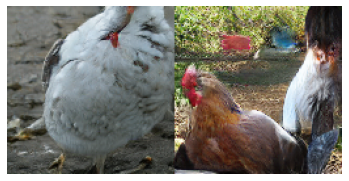

In [ ]:
print("Start sampling...")

for y in [8]: # class info
  outputs = []
  z = sampler.get_noise(batch_size, truncate=None)
  fakes = sampler.sample(z, labels=np.asarray([y] * batch_size))
  outputs.append(np.concatenate(fakes, axis=1))
  for output in outputs:
      display_image_ndarray(output)